In [294]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [295]:
import matplotlib.pyplot as plt
import numpy as np

import torch

from itertools import product
from itertools import combinations
import pickle
import datetime

from scipy.special import logsumexp

from Bio.Phylo.TreeConstruction import _DistanceMatrix
from Bio.Phylo.TreeConstruction import DistanceTreeConstructor
from Bio.Phylo.TreeConstruction import DistanceCalculator
from io import StringIO
from Bio import Phylo

from tree_torch import Tree
from SLCVI_torch import SLCVI

import warnings
warnings.filterwarnings('ignore')

from copy import deepcopy

np.random.seed(0)

In [296]:
data_set = "DS2"
pop_size = 5.0 # exponential parameter for constant pop size prior
data_file = '../dat/'+data_set+'/'+data_set+'.pickle'
time = datetime.datetime.now().strftime('%Y_%m_%d_%H_%M_%S')
reparam_file = '../results/'+data_set+'/'+data_set+'_'+time+'_reparam.pickle'
reinforce_file = '../results/'+data_set+'/'+data_set+'_'+time+'_reinforce.pickle'
VIMCO_file = '../results/'+data_set+'/'+data_set+'_'+time+'_VIMCO.pickle'

In [297]:
with open(data_file, 'rb') as f:
    DS1 = pickle.load(f)

In [298]:
genomes = []
species = []
for key in DS1:
    genomes.append(DS1[key])
    species.append(key)
    
n_species = len(species)

In [299]:
# From https://github.com/zcrabbit/vbpi-torch/blob/ff86cf0c47a5753f5cc5b4dfe0b6ed783ab22669/unrooted/phyloModel.py#L7-L11
nuc2vec = {'A':[1.,0.,0.,0.], 'G':[0.,1.,0.,0.], 'C':[0.,0.,1.,0.], 'T':[0.,0.,0.,1.],
           '-':[1.,1.,1.,1.], '?':[1.,1.,1.,1.], 'N':[1.,1.,1.,1.], 'R':[1.,1.,0.,0.],
           'Y':[0.,0.,1.,1.], 'S':[0.,1.,1.,0.], 'W':[1.,0.,0.,1.], 'K':[0.,1.,0.,1.],
           'M':[1.,0.,1.,0.], 'B':[0.,1.,1.,1.], 'D':[1.,1.,0.,1.], 'H':[1.,0.,1.,1.],
           'V':[1.,1.,1.,0.], '.':[1.,1.,1.,1.], 'U':[0.,0.,0.,1.], 'n':[1.,1.,1.,1.]}

tree_log_probs = torch.tensor([[nuc2vec[g] for g in genome] for genome in genomes],
                                dtype = torch.float64)
tree_log_probs = torch.log(tree_log_probs)

# Set initial $\theta$ using expected number of changes

In [300]:
times = torch.zeros((n_species,n_species))

for i in range(n_species):
    for j in range(n_species):
        eq = [x != y for x,y in zip(genomes[i],genomes[j]) if ((x in ["A","C","T","G"]) and (y in ["A","C","T","G"]))]
        times[i,j] = np.mean(eq) + 1/(len(eq))

In [301]:
log_times = torch.log(times)
log_times = log_times + torch.triu(torch.full((n_species,n_species), float("Inf")))


tree = Tree(theta,log_times,tree_log_probs,
            pop_size=pop_size)

theta = torch.zeros((2,n_species,n_species))

for node in tree.nodes:
    combs = combinations(node.leaves,2)
    for inds in combs:
        inds = sorted(inds)
        theta[0,inds[1],inds[0]] = min(theta[0,inds[1],inds[0]],torch.log(node.coal_time))
        theta[1,inds[1],inds[0]] = -2

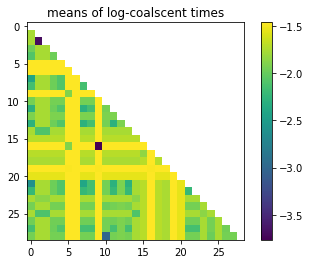

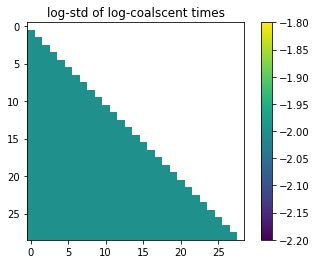

In [302]:
m = deepcopy(theta[0])
m[np.triu_indices(m.shape[0])] = np.nan
plt.imshow(m)
plt.title("means of log-coalscent times")
plt.colorbar()
plt.show()

log_sig = deepcopy(theta[1])
log_sig[np.triu_indices(log_sig.shape[0])] = np.nan
plt.imshow(log_sig)
plt.title("log-std of log-coalscent times")
plt.colorbar()
plt.show()

# Make Neighbor Joining initial guess

In [303]:
times = np.zeros((n_species,n_species))

for i in range(n_species):
    for j in range(n_species):
        eq = [x != y for x,y in zip(genomes[i],genomes[j]) if ((x in ["A","C","T","G"]) and (y in ["A","C","T","G"]))]
        p_hat = np.mean(eq)
        
        times[i,j] = np.mean(eq)

matrix = []
for i,row in enumerate(times):
    matrix.append(list(row[:(i+1)]))
m = _DistanceMatrix(species, matrix)
calculator = DistanceCalculator('identity')
constructor = DistanceTreeConstructor(calculator, 'upgma')
tree = constructor.nj(m)

theta = torch.zeros((2,n_species,n_species))
for i in range(n_species):
    for j in range(i):
        n = sum([((x in ["A","C","T","G"]) and (y in ["A","C","T","G"])) for x,y in zip(genomes[i],genomes[j])])
        m = max(0,tree.distance(target1=species[i],target2=species[j])) + (1/(n+2))
        v = m*(1.0-m) / (n+1)
        sig2 = np.log(v/(m*m) + 1.0)
        mu = np.log(m) - sig2/2.0
        theta[0,i,j] = mu
        theta[1,i,j] = np.log(sig2)/2.0
        if np.isnan(mu):
            print(i,j)
            print(n)
            print(m)

#theta = np.zeros((2,n_species,n_species))
#for i in range(n_species):
#    for j in range(i):
#        theta[0,i,j] = np.log(tree.distance(target1=species[i],target2=species[j]))
#        theta[1,i,j] = -2

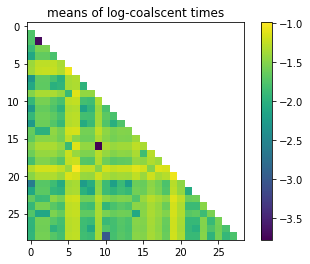

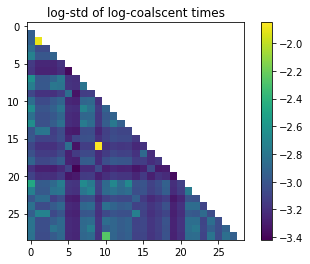

In [304]:
m = deepcopy(theta[0])
m[np.triu_indices(m.shape[0])] = np.nan
plt.imshow(m)
plt.title("means of log-coalscent times")
plt.colorbar()
plt.show()

log_sig = deepcopy(theta[1])
log_sig[np.triu_indices(log_sig.shape[0])] = np.nan
plt.imshow(log_sig)
plt.title("log-std of log-coalscent times")
plt.colorbar()
plt.show()

# set $\theta$ using BEAST empirical values

In [305]:
treedata = ""
ntrees = 0

for i in range(1):
    
    tree_file = "../dat/"+data_set+"/"+data_set+"_fixed_pop_support_short_run_rep_%d.trees"%(i+1)

    with open(tree_file, "r") as file:
        for line in file:
            if line.startswith("tree STATE"):

                # start at first (
                line = line[line.find('('):]

                # remove 
                line = line.replace("[&rate=1.0]","")

                # print line
                #print(line)

                treedata = treedata + line + "\n"

                ntrees += 1

In [306]:
theta = torch.zeros((2,n_species,n_species))
trees = Phylo.parse(StringIO(treedata), "newick")
log_dists = np.zeros((ntrees,n_species,n_species))

for i,tree in enumerate(trees):
    print(i/ntrees)
    for j in range(n_species):
        for k in range(j):
            log_dists[i,j,k] = np.log(tree.distance(target1=str(j+1),target2=str(k+1))/2.0)

for j in range(n_species):
    for k in range(j):
        theta[0,j,k] = np.mean(log_dists[:,j,k])
        theta[1,j,k] = np.log(np.std(log_dists[:,j,k]))


#treedata = write_newick(tree.nodes[-1])
#handle = StringIO(treedata)
#tree_to_draw = Phylo.read(handle, "newick")

0.0
0.000999000999000999
0.001998001998001998
0.002997002997002997
0.003996003996003996
0.004995004995004995
0.005994005994005994
0.006993006993006993
0.007992007992007992
0.008991008991008992
0.00999000999000999
0.01098901098901099
0.011988011988011988
0.012987012987012988
0.013986013986013986
0.014985014985014986
0.015984015984015984
0.016983016983016984
0.017982017982017984
0.01898101898101898
0.01998001998001998
0.02097902097902098
0.02197802197802198
0.022977022977022976
0.023976023976023976
0.024975024975024976
0.025974025974025976
0.026973026973026972
0.027972027972027972
0.028971028971028972
0.029970029970029972
0.030969030969030968
0.03196803196803197
0.03296703296703297
0.03396603396603397
0.03496503496503497
0.03596403596403597
0.03696303696303696
0.03796203796203796
0.03896103896103896
0.03996003996003996
0.04095904095904096
0.04195804195804196
0.04295704295704296
0.04395604395604396
0.04495504495504495
0.04595404595404595
0.04695304695304695
0.04795204795204795
0.048951048

0.4155844155844156
0.4165834165834166
0.4175824175824176
0.41858141858141856
0.4195804195804196
0.4205794205794206
0.42157842157842157
0.4225774225774226
0.42357642357642356
0.4245754245754246
0.4255744255744256
0.42657342657342656
0.4275724275724276
0.42857142857142855
0.42957042957042957
0.4305694305694306
0.43156843156843155
0.4325674325674326
0.43356643356643354
0.43456543456543456
0.4355644355644356
0.43656343656343655
0.43756243756243757
0.4385614385614386
0.43956043956043955
0.4405594405594406
0.44155844155844154
0.44255744255744256
0.4435564435564436
0.44455544455544455
0.44555444555444557
0.44655344655344653
0.44755244755244755
0.4485514485514486
0.44955044955044954
0.45054945054945056
0.4515484515484515
0.45254745254745254
0.45354645354645357
0.45454545454545453
0.45554445554445555
0.4565434565434565
0.45754245754245754
0.45854145854145856
0.4595404595404595
0.46053946053946054
0.46153846153846156
0.46253746253746253
0.46353646353646355
0.4645354645354645
0.46553446553446554


0.8451548451548452
0.8461538461538461
0.8471528471528471
0.8481518481518482
0.8491508491508492
0.8501498501498501
0.8511488511488512
0.8521478521478522
0.8531468531468531
0.8541458541458542
0.8551448551448552
0.8561438561438561
0.8571428571428571
0.8581418581418582
0.8591408591408591
0.8601398601398601
0.8611388611388612
0.8621378621378621
0.8631368631368631
0.8641358641358642
0.8651348651348651
0.8661338661338661
0.8671328671328671
0.8681318681318682
0.8691308691308691
0.8701298701298701
0.8711288711288712
0.8721278721278721
0.8731268731268731
0.8741258741258742
0.8751248751248751
0.8761238761238761
0.8771228771228772
0.8781218781218781
0.8791208791208791
0.8801198801198801
0.8811188811188811
0.8821178821178821
0.8831168831168831
0.8841158841158842
0.8851148851148851
0.8861138861138861
0.8871128871128872
0.8881118881118881
0.8891108891108891
0.8901098901098901
0.8911088911088911
0.8921078921078921
0.8931068931068931
0.8941058941058941
0.8951048951048951
0.8961038961038961
0.8971028971

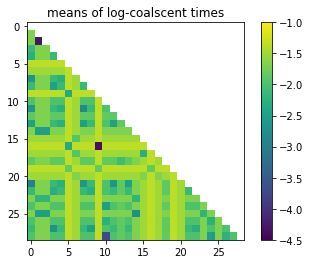

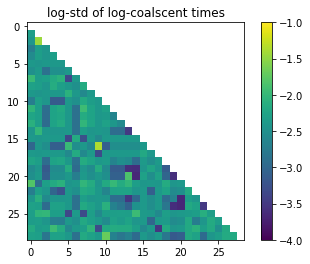

In [311]:
m = deepcopy(theta[0])
m[np.triu_indices(m.shape[0])] = np.nan
plt.imshow(m,vmin=-4.5,vmax=-1)
plt.title("means of log-coalscent times")
plt.colorbar()
plt.show()

log_sig = deepcopy(theta[1])
log_sig[np.triu_indices(log_sig.shape[0])] = np.nan
plt.imshow(log_sig, vmin = -4, vmax=-1)
plt.title("log-std of log-coalscent times")
plt.colorbar()
plt.show()

# perform variational inference

In [72]:
optim_reparam = SLCVI(tree_log_probs,deepcopy(theta),pop_size)
optim_reparam.learn(batch_size=10,
                    iters=100,
                    alpha=0.01,
                    method="reparam",
                    record_every=10,
                    pop_size=pop_size)

print("final theta:",optim_reparam.theta)
print("final gradient:",optim_reparam.theta.grad)
plt.plot(optim_reparam.ELBO_ests)

KeyboardInterrupt: 

In [ ]:
plt.plot(optim_reparam.ELBO_ests)
plt.show()
plt.plot(np.log(optim_reparam.grad_norms))
plt.show()

m = deepcopy(optim_reparam.theta[0].detach())
m[np.triu_indices(m.shape[0])] = np.nan
plt.imshow(m)
plt.title("means of log-coalscent times")
plt.colorbar()
plt.show()

log_sig = deepcopy(optim_reparam.theta[1].detach())
log_sig[np.triu_indices(log_sig.shape[0])] = np.nan
plt.imshow(log_sig)
plt.title("log-std of log-coalscent times")
plt.colorbar()
plt.show()

In [131]:
with open(reparam_file, 'wb') as file: 
    pickle.dump(optim_reparam, file) 

PicklingError: Can't pickle <class 'SLCVI_torch.SLCVI'>: it's not the same object as SLCVI_torch.SLCVI

In [132]:
optim_reinforce = SLCVI(tree_log_probs,deepcopy(theta),pop_size)
optim_reinforce.learn(batch_size=10,
                      iters=1000,
                      alpha=0.01,
                      method="reinforce",
                      record_every=10,
                      pop_size=pop_size)

print("final theta:",optim_reinforce.theta)
print("final gradient:",optim_reinforce.theta.grad)
plt.plot(optim_reinforce.ELBO_ests)

iteration:  0
runtime: 0 mins
grad_norm estimate:  817.5942544636462
ELBO estimate:  -7499.582463637448



KeyboardInterrupt: 

In [ ]:
plt.plot(optim_reinforce.ELBO_ests)
plt.show()
plt.plot(np.log(optim_reinforce.grad_norms))
plt.show()

m = deepcopy(optim_reinforce.theta[0].detach())
m[np.triu_indices(m.shape[0])] = np.nan
plt.imshow(m)
plt.title("means of log-coalscent times")
plt.colorbar()
plt.show()

log_sig = deepcopy(optim_reinforce.theta[1].detach())
log_sig[np.triu_indices(log_sig.shape[0])] = np.nan
plt.imshow(log_sig)
plt.title("log-std of log-coalscent times")
plt.colorbar()

In [ ]:
with open(reinforce_file, 'wb') as file: 
    pickle.dump(optim_reinforce, file) 

In [ ]:
optim_VIMCO = SLCVI(tree_log_probs,deepcopy(theta),pop_size)
optim_VIMCO.learn(batch_size=10,
                  iters=1000,
                  alpha=0.01,
                  method="VIMCO",
                  record_every=10,
                  test_batch_size=100,
                  pop_size=pop_size)

print("final theta:",optim_VIMCO.theta)
print("final gradient:",optim_VIMCO.theta.grad)
plt.plot(optim_VIMCO.ELBO_ests)

In [ ]:
plt.plot(optim_VIMCO.ELBO_ests)
plt.show()
plt.plot(np.log(optim_VIMCO.grad_norms))
plt.show()

m = deepcopy(optim_VIMCO.theta[0].detach())
m[np.triu_indices(m.shape[0])] = np.nan
plt.imshow(m)
plt.title("means of log-coalscent times")
plt.colorbar()
plt.show()

log_sig = deepcopy(optim_VIMCO.theta[1].detach())
log_sig[np.triu_indices(log_sig.shape[0])] = np.nan
plt.imshow(log_sig)
plt.title("log-std of log-coalscent times")
plt.colorbar()

In [ ]:
with open(reinforce_file, 'wb') as file: 
    pickle.dump(optim_VIMCO, file) 

In [102]:
optim = optim_reinforce
theta = optim.theta

# draw the random tree using a newick file

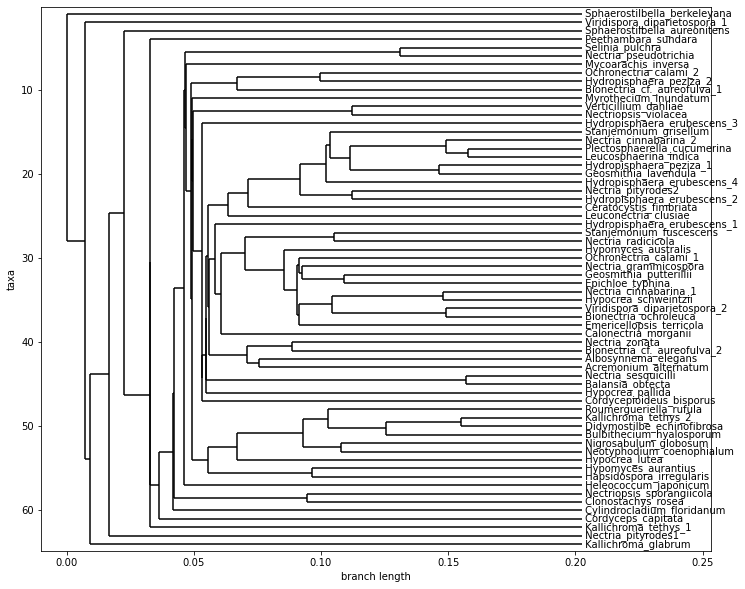

-15626.892039227627
-142.45654517761741
-15769.348584405245


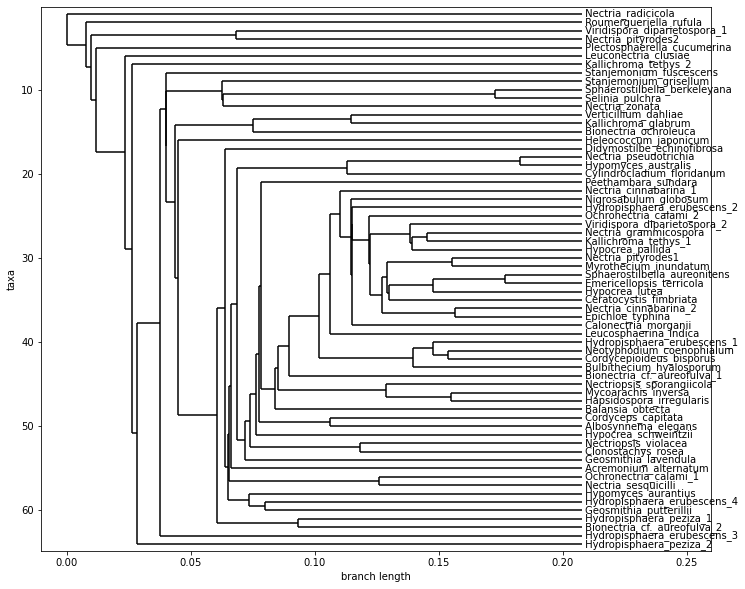

-15329.192033292664
-137.28074729466047
-15466.472780587324


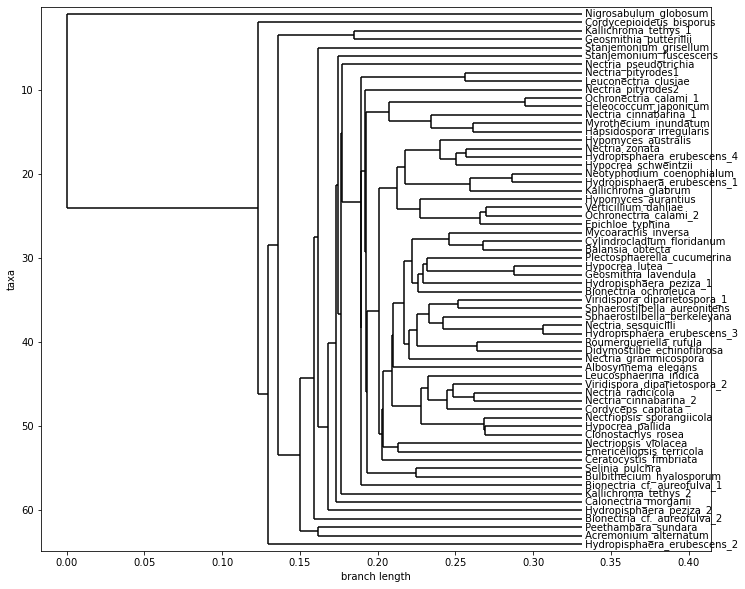

-15399.022514774175
-137.13998333471355
-15536.162498108888


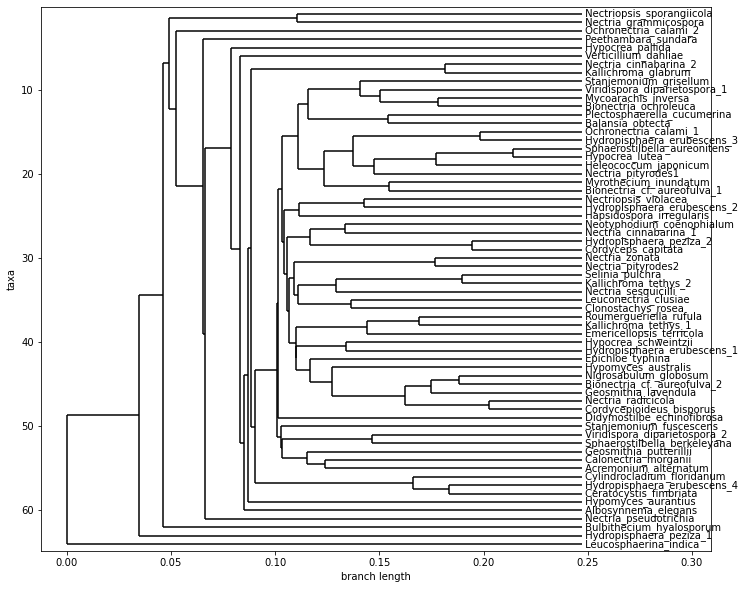

-15601.092288296994
-140.81694330880993
-15741.909231605803


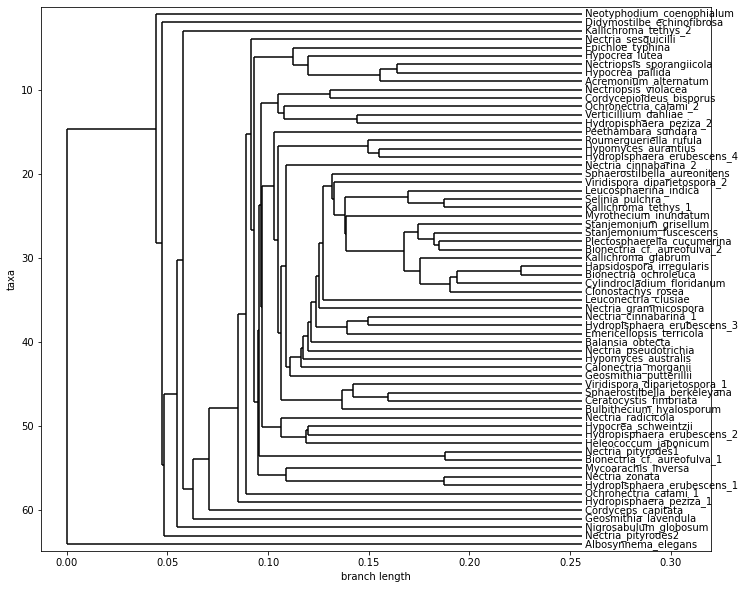

-15846.007182807622
-145.0499446386536
-15991.057127446275


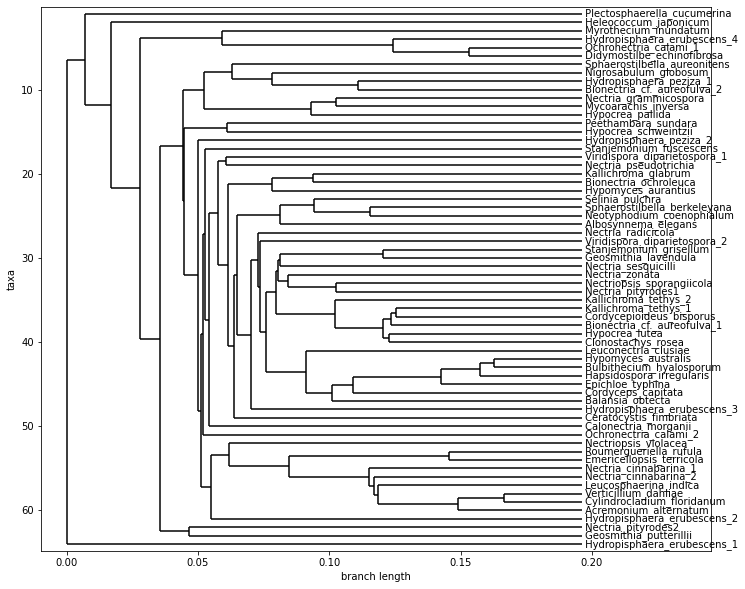

-15161.589292350543
-137.62918355043493
-15299.218475900978


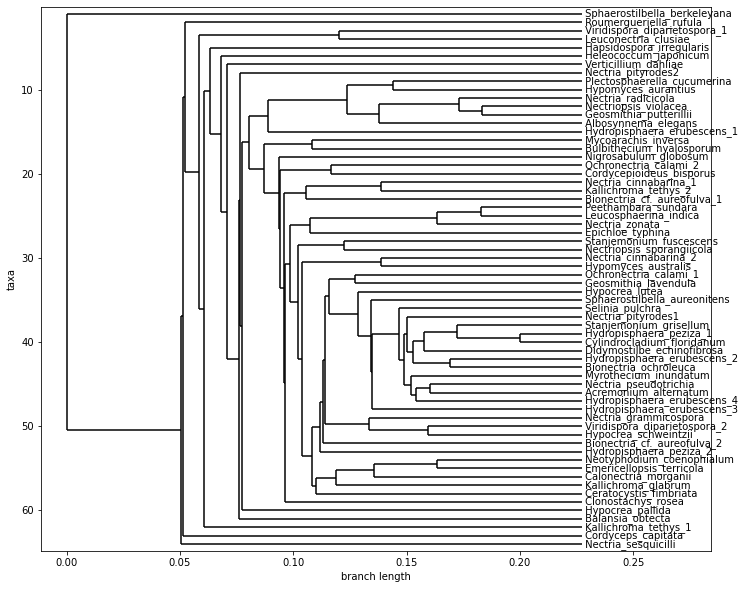

-15116.278530024189
-137.0213960683784
-15253.299926092566


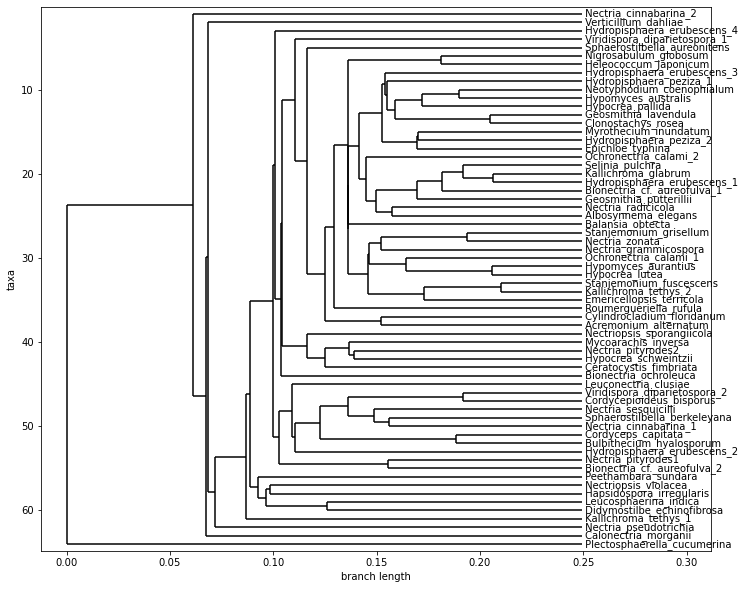

-14967.493623540959
-137.2273660324837
-15104.720989573443


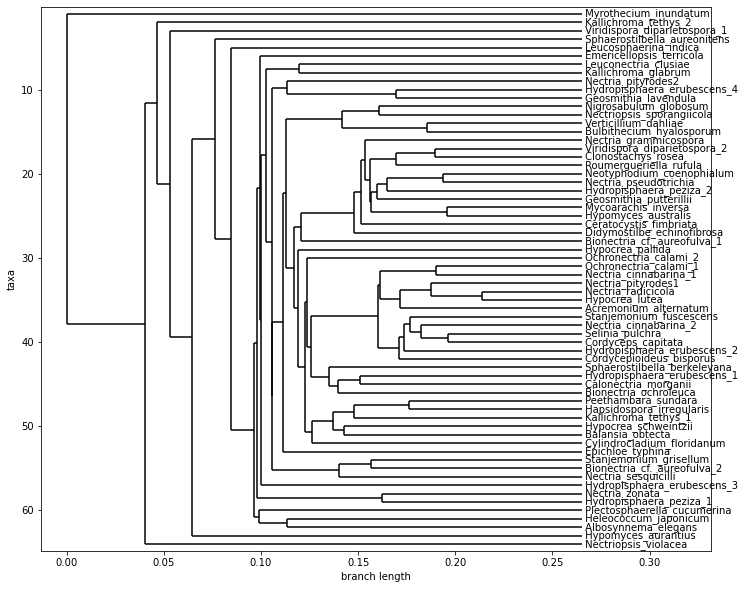

-15771.711213889292
-144.15034655114184
-15915.861560440433


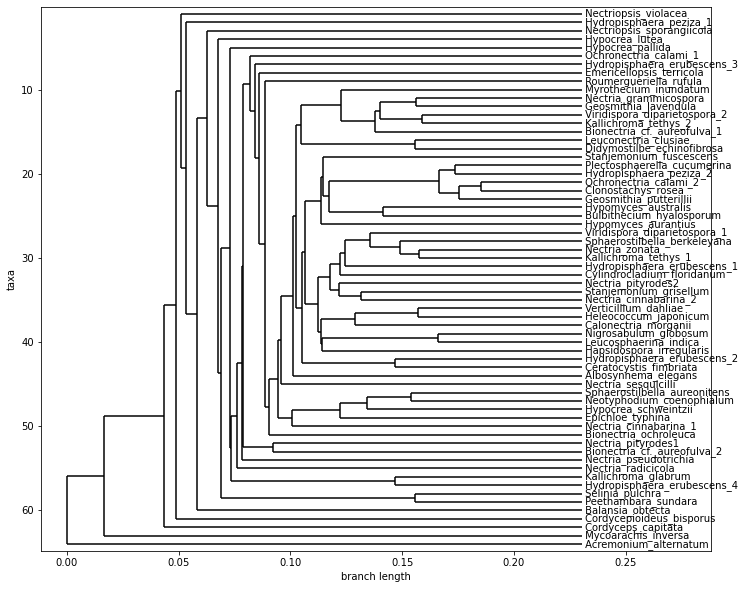

-15451.536883702029
-140.84432315876558
-15592.381206860795


In [228]:
def write_newick(node):

    if node.children == []:
        return species[next(iter(node.leaves))] + ":" + str(node.parent.coal_time.item())
    elif node.parent is None:
        return "(" + write_newick(node.children[0]) + "," + write_newick(node.children[1]) + ")"
    else:
        bl = node.parent.coal_time.item() - node.coal_time.item()
        return "(" + write_newick(node.children[0]) + "," + write_newick(node.children[1]) + "):" + str(bl)
    
for _ in range(10):
    Z = torch.normal(mean=0.0,std=1.0,size=(n_species,n_species))
    log_times = torch.exp(theta[1])*Z+theta[0]
    log_times = log_times + torch.triu(torch.full((n_species,n_species), float("Inf")))

    tree = Tree(theta,log_times,tree_log_probs,
                pop_size=pop_size)

    treedata = write_newick(tree.nodes[-1])
    handle = StringIO(treedata)
    tree_to_draw = Phylo.read(handle, "newick")

    # Set up the plot
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(1, 1, 1)

    # Draw the phylogenetic tree
    Phylo.draw(tree_to_draw, axes=ax)

    print(tree.log_like.item())
    print(tree.log_prior.item())
    print(tree.log_p.item())

# Estimate the marginal likelihood

In [103]:
n_exp = 10
n_samples = 100

# get priors and log-liklihoods
priors = []
LL = []

# get log_qs
log_qs = []

# get root heights
rootHeights = []

# get tree topologies
tree_hash = {}
top_counts = {}

# get marginal log-likelihoods and ELBOs
MLL_all = np.zeros(n_exp)
ELBO_all = np.zeros(n_exp)

with torch.no_grad():
    for i in range(n_exp):

        print(i)
        MLL = np.zeros(n_samples)
        ELBO = np.zeros(n_samples)

        for j in range(n_samples):
            Z = torch.normal(mean=0.0,std=1.0,size=(n_species,n_species))
            log_times = torch.exp(theta[1])*Z+theta[0]
            log_times = log_times + torch.triu(torch.full((n_species,n_species), float("Inf")))
            tree = Tree(optim.theta,
                        log_times,
                        deepcopy(tree_log_probs),
                        pop_size=pop_size)

            MLL[j] = tree.log_p.item() - tree.log_q.item()
            ELBO[j] = tree.log_p.item() - tree.log_q.item()

            LL.append(tree.log_like.item())
            priors.append(tree.log_prior.item())
            log_qs.append(tree.log_q.item())
            rootHeights.append(tree.nodes[-1].coal_time.item())

            tree_top = frozenset([frozenset(x.leaves) for x in tree.nodes])
            if tree_top in tree_hash:
                top_counts[tree_hash[tree_top]] += 1
            else:
                tree_hash[tree_top] = len(tree_hash)
                top_counts[tree_hash[tree_top]] = 1

        MLL_all[i] = logsumexp(MLL) - np.log(n_samples)
        ELBO_all[i] = np.mean(ELBO)

0
1
2
3
4
5
6
7
8
9


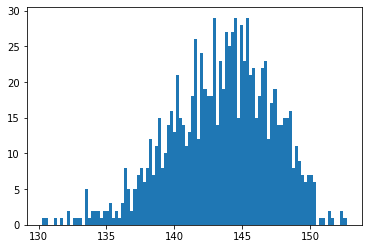

143.46433505458214


In [104]:
plt.hist(log_qs,bins = 100)
plt.show()
print(np.mean(log_qs))

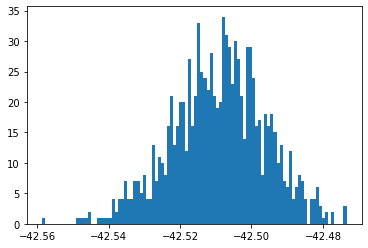

-42.50910236394554


In [105]:
plt.hist(priors,bins = 100)
plt.show()
print(np.mean(priors))

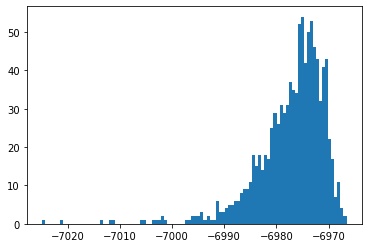

-6977.177121521376


In [106]:
plt.hist(LL,bins = 100)
plt.show()
print(np.mean(LL))

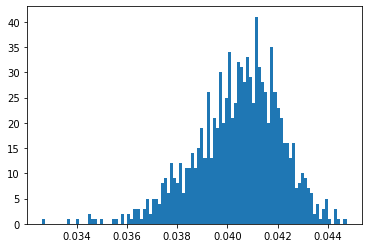

0.04042246175528179


In [107]:
plt.hist(rootHeights,bins = 100)
plt.show()
print(np.mean(rootHeights))

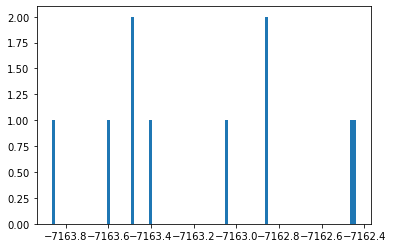

-7163.150558939904


In [108]:
plt.hist(ELBO_all,bins = 100)
plt.show()
print(np.mean(ELBO_all))

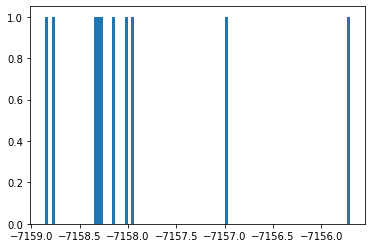

-7157.934354856084


In [109]:
plt.hist(MLL_all,bins = 100)
plt.show()
print(np.mean(MLL_all))

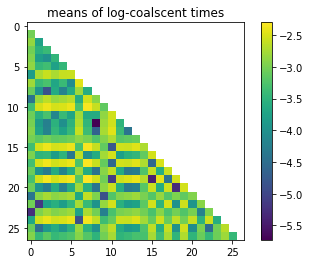

In [110]:
m = deepcopy(theta[0].detach())
m[np.triu_indices(m.shape[0])] = np.nan
plt.imshow(m)
plt.title("means of log-coalscent times")
plt.colorbar()

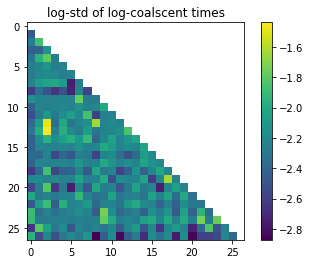

In [111]:
log_sig = deepcopy(theta[1].detach())
log_sig[np.triu_indices(log_sig.shape[0])] = np.nan
plt.imshow(log_sig)
plt.title("log-std of log-coalscent times")
plt.colorbar()